In [1]:
import sys
sys.path.insert(1, './lib/')

# Discovering Classic Rock Subgenres
### Team Diatonics | CS 418 | Spring 2020

### Team Members
* Leopoldo Gomez (`lgomez36@uic.edu`, `pologomez`), Matthew Searcy (`msearc2@uic.edu`, `MatthewSearcy`),  Matt Rusnaczyk (`mrusna4@uic.edu`, `mrusnaczyk`), Faraz Shakir (`fshaki3@uic.edu`, `FShakir`), Mahdi Moghaddam (`mmogha2@uic.edu`, `mahdimo5595`)

## Project Introduction
The main idea of this project is to see if a clustering method can be used to subdivide a large pool of songs that are deemed to be part of the same genre into smaller subgenres. A potential audience for this analysis would be people who are trying to get into a new gerne. Being able to listen to a selection of songs from each subgroup could make it easier to figure out what type of bands they'd enjoy listening to. 

We use a precompiled [dataset](https://github.com/fivethirtyeight/data/blob/master/classic-rock/classic-rock-song-list.csv) of classic rock songs and get their audio features via spotify's API. We decided to use classic rock as our genre because it is one of the broadest genres of music with many distinct characteristic sounds and sub-cultures.

## Data Acquisition and Cleaning

Our analysis is based on two sets of data. The first is the [Classic Rock Song List from FiveThirtyEight](https://github.com/fivethirtyeight/data/blob/master/classic-rock/classic-rock-song-list.csv); the second is the audio features data made available by Spotify through their [RESTful API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

First, we read in the data from the classic rock songs dataset, then we transform the data into a list consisting of each track and artist concatenated into one string. Converting into this format allows us to more easily search for the tracks in Spotify later on.

In [2]:
import data_acquisition_cleaning as data
raw_song_data = data.load_song_data()
title_artist = data.get_title_artist(raw_song_data)

Next, we take the title/artist strings we generated earlier, and retrieve the corresponding Spotify resource URLs for each:

In [3]:
%%capture
import spotify
spotify_client = spotify.get_spotify_client()
tracks_to_query = spotify.get_spotify_resource_urls(title_artist, spotify_client)

Then, we use the Spotify API to retrieve the audio features for each of the songs in the list, and add the track name and artist back in:

In [4]:
%%capture
tracks_with_audio_features = spotify.audio_features(tracks_to_query, spotify_client)

And this is the resulting dataset:

In [5]:
tracks_with_audio_features.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,title,artist
0,0.425,0.681,1,-8.604,0.0316,0.02290,0.000219,0.0543,0.933,131.011,Caught Up in You,.38 Special
1,0.418,0.775,4,-9.591,0.0333,0.05310,0.001250,0.0932,0.845,123.524,Fantasy Girl,.38 Special
2,0.567,0.559,9,-10.175,0.0288,0.00888,0.001310,0.0764,0.898,127.227,Hold On Loosely,.38 Special
3,0.659,0.505,0,-12.773,0.0302,0.05300,0.000000,0.0544,0.879,128.295,Rockin' Into the Night,.38 Special
4,0.646,0.426,0,-10.629,0.0480,0.08580,0.072700,0.0746,0.462,124.794,Art For Arts Sake,10cc


## Exploratory Data Analysis

As the name of the dataset would imply (Classic Rock Song List), the scope of the music we are studying is limited to a subset of popular classic rock tracks. The data was collected by [FiveThirtyEight](https://fivethirtyeight.com/features/why-classic-rock-isnt-what-it-used-to-be/) by monitoring the track histories of 25 classic rock stations across the U.S. Below are the artists included in the dataset, and the number of their songs that are listed:

In [6]:
data.get_artists_and_song_count(raw_song_data)

,Artist Name,Num Songs Included
393,The Beatles,100
229,Led Zeppelin,69
321,Rolling Stones,55
453,Van Halen,44
291,Pink Floyd,39
...,...,...
131,Everlast,1
322,Rory Gallagher,1
323,Royal Bliss,1
129,Eve 6,1


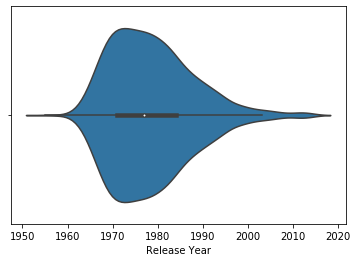

In [7]:
import viz
viz.get_release_year_distribution_graph(raw_song_data)

If we take a closer look at the data, we can see that each row represents one song and its Spotify properties:

In [8]:
tracks_with_audio_features.head(1)

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,title,artist
0,0.425,0.681,1,-8.604,0.0316,0.0229,0.000219,0.0543,0.933,131.011,Caught Up in You,.38 Special


The data is also not aggregated in any way, as all of the rows from the Classic Rock Song List dataset were each one track, and the Spotify data listed in each row is relevant only to the song in that row.

In [9]:
eda_data = tracks_with_audio_features.copy().dropna()
try:
    eda_data = eda_data.drop(columns=['cluster', 'tempo'])
except:
    None
eda_data.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2173.000000,2173.000000,2173.000000,2173.000000,2173.000000,2173.000000,2173.000000,2173.000000,2173.000000,2173.000000
mean,0.524486,0.688442,5.011045,-8.954028,0.052361,0.183778,0.068091,0.207103,0.601625,124.142312
std,0.140185,0.193194,3.509769,3.339092,0.039936,0.219913,0.183925,0.190149,0.228649,26.983122
min,0.000000,0.012400,0.000000,-23.340000,0.000000,0.000001,0.000000,0.012000,0.000000,0.000000
25%,0.432000,0.554000,2.000000,-11.239000,0.032400,0.015300,0.000007,0.086400,0.430000,105.407000
50%,0.531000,0.716000,5.000000,-8.756000,0.039900,0.089800,0.000478,0.131000,0.614000,123.416000
75%,0.622000,0.848000,9.000000,-6.363000,0.056100,0.290000,0.015500,0.271000,0.788000,139.739000
max,0.952000,0.995000,11.000000,-1.525000,0.507000,0.971000,0.949000,0.992000,0.990000,215.918000


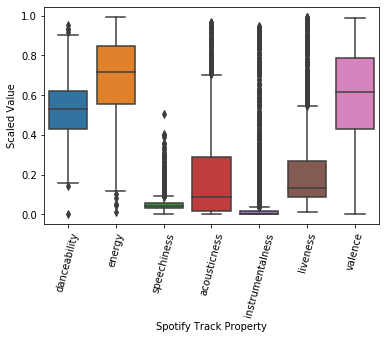

In [10]:
viz.spotify_property_dist_graph(eda_data)

### Track Property Analysis

Based on the dataset's distribution for each of track properties, we can see some properties are more consistent than others. For instance, a majority of the songs have low acousticness with some outliers. This can be attributed to 80's hard rock's tendency to use distorted guitars, with some other country-oriented songs using acoustic instruments. The danceability and energy properties have lower variance as well. Speechiness and instrumentalness have by far the most variance. This is because there are classic rock songs that are completely instrumental, some that feature vocals throughout, and every degree of instrumentality between.
One potential hypothesis we have is that we can use this song property variety to group classic rock songs into subgenres (i.e. hard rock, country rock, power ballad, etc.)

## Machine Learning Analysis

We scale loudness, key, and tempo so the values of all features are between 0 and 1

In [11]:
import ml_analysis as ml
ml.scale_columns(['loudness', 'key', 'tempo'], tracks_with_audio_features)

Next we cluster the tracks and find the centers for each of the clusters

In [12]:
(tracks_with_audio_features,center) = ml.cluster_songs(tracks_with_audio_features, 50)

In [13]:
tracks_with_audio_features.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,title,artist,cluster_km,cluster_ag
0,0.425,0.681,0.090909,0.675499,0.0316,0.02290,0.000219,0.0543,0.933,0.606763,Caught Up in You,.38 Special,49,0
1,0.418,0.775,0.363636,0.630254,0.0333,0.05310,0.001250,0.0932,0.845,0.572088,Fantasy Girl,.38 Special,6,29
2,0.567,0.559,0.818182,0.603484,0.0288,0.00888,0.001310,0.0764,0.898,0.589238,Hold On Loosely,.38 Special,27,26
3,0.659,0.505,0.000000,0.484391,0.0302,0.05300,0.000000,0.0544,0.879,0.594184,Rockin' Into the Night,.38 Special,34,0
4,0.646,0.426,0.000000,0.582672,0.0480,0.08580,0.072700,0.0746,0.462,0.577969,Art For Arts Sake,10cc,1,3


Now, we can recommend similar songs to users based on the cluster that they belong to. For example, someone who listens to 'Back in Black' might also enjoy the following songs:

In [15]:
ml.recommend('Back In Black', "AC/DC", tracks_with_audio_features, spotify_client,tracks_to_query).head(10)

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [16]:
ml.recommend('Roar', "katy perry", tracks_with_audio_features, spotify_client,tracks_to_query).head(10)

AttributeError: 'DataFrame' object has no attribute 'cluster'

## Visualizing the results
---

In [ ]:
viz.plot_TSNE(tracks_with_audio_features)

In [ ]:
viz.compare_center_features(center)

## Conclusion
---